In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
img1 = cv2.imread('./images/q8_5.jpg')
img2 = cv2.imread('./images/q8_6.png')
img3 = cv2.imread('./images/q8_7.png')

In [4]:
def get_neighborhood(image, i, j):
    # Extract the neighborhood using array slicing
    neighborhood = image[i-1:i+2, j-1:j+2]
    # Flatten the neighborhood and remove the center element
    flattened = neighborhood.flatten()
    flattened = np.delete(flattened, 4)
    return tuple(flattened)

In [5]:
def zhang_suen_thinning(image):
    # Normalize the image to 0 and 1
    image = image // 255
    # Create an empty array for the skeleton
    skeleton = np.zeros_like(image)
    
    # Iterate over each pixel in the image, excluding the border pixels
    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            # Obtain the 8-neighborhood of the current pixel
            p2, p3, p4, p5, p6, p7, p8, p9 = get_neighborhood(image, i, j)
            
            # Compute the values of A and B
            A = (p2 + p3 + p4 + p5 + p6 + p7 + p8 + p9) / 255
            B = sum(abs(p - q) for p, q in zip([p2, p3, p4, p5, p6, p7, p8, p9], [p2, p3, p4, p5, p6, p7, p8, p9])) / 255
            
            # Apply conditions for thinning
            m1 = (p2 * p4 * p6) if 2 <= A <= 6 and B == 1 else 0
            m2 = (p4 * p6 * p8) if 2 <= A <= 6 and B == 1 else 0
            
            # If both conditions are satisfied, set the pixel value in the skeleton
            if m1 == 0 and m2 == 0:
                skeleton[i, j] = image[i, j]
    
    # Scale the skeleton back to 0-255 range and return
    return skeleton * 255

In [6]:
def thinning(image):
    skeleton = image.copy()
    skeleton_prev = np.zeros_like(image)
    while True:
        # Apply Zhang-Suen thinning algorithm
        skeleton_prev = skeleton.copy()
        skeleton = zhang_suen_thinning(skeleton)
        if np.array_equal(skeleton_prev, skeleton):
            break
    return skeleton

In [7]:
# Modified erode function
def erode(binary, kernel_size=(3, 3)):
    kh, kw = kernel_size
    eroded = np.zeros_like(binary)
    height, width = binary.shape
    for i in range(height):
        for j in range(width):
            # Check if all elements in the kernel region are 255
            if np.all(binary[max(0, i-kh//2):min(height, i+kh//2+1), max(0, j-kw//2):min(width, j+kw//2+1)] == 255):
                eroded[i, j] = 255
    return eroded

In [8]:
# Modified dilate function
def dilate(binary, kernel_size=(3, 3)):
    kh, kw = kernel_size
    dilated = np.zeros_like(binary)
    height, width = binary.shape
    for i in range(height):
        for j in range(width):
            # Check if any element in the kernel region is 255
            if np.any(binary[max(0, i-kh//2):min(height, i+kh//2+1), max(0, j-kw//2):min(width, j+kw//2+1)] == 255):
                dilated[i, j] = 255
    return dilated

In [9]:
def skeletoniztion(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Thresholding
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    skeleton = np.zeros_like(binary)
    temp = np.zeros_like(binary)
    while True:
        eroded = erode(binary)
        dilated = dilate(eroded)
        temp = cv2.subtract(binary, dilated)
        skeleton = cv2.bitwise_or(skeleton, temp)
        binary = eroded.copy()

        # Exit loop if no further changes
        if cv2.countNonZero(binary) == 0:
            break
    skeleton = thinning(skeleton)
    return skeleton

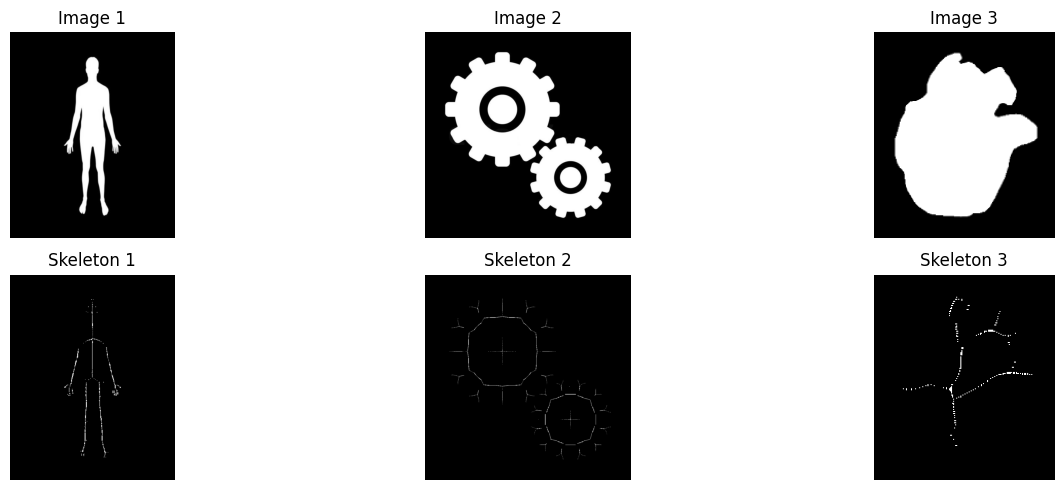

In [10]:
# Apply skeletonization for images
s1 = skeletoniztion(img1)
s2 = skeletoniztion(img2)
s3 = skeletoniztion(img3)

# Plot the original and skeleton images
plt.figure(figsize=(15, 5))

# Image 1
plt.subplot(2, 3, 1)
plt.imshow(img1)
plt.title("Image 1")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(s1, cmap='gray')
plt.title("Skeleton 1")
plt.axis("off")

# Image 2
plt.subplot(2, 3, 2)
plt.imshow(img2)
plt.title("Image 2")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(s2, cmap='gray')
plt.title("Skeleton 2")
plt.axis("off")

# Image 3
plt.subplot(2, 3, 3)
plt.imshow(img3)
plt.title("Image 3")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(s3, cmap='gray')
plt.title("Skeleton 3")
plt.axis("off")

plt.tight_layout()
plt.show()

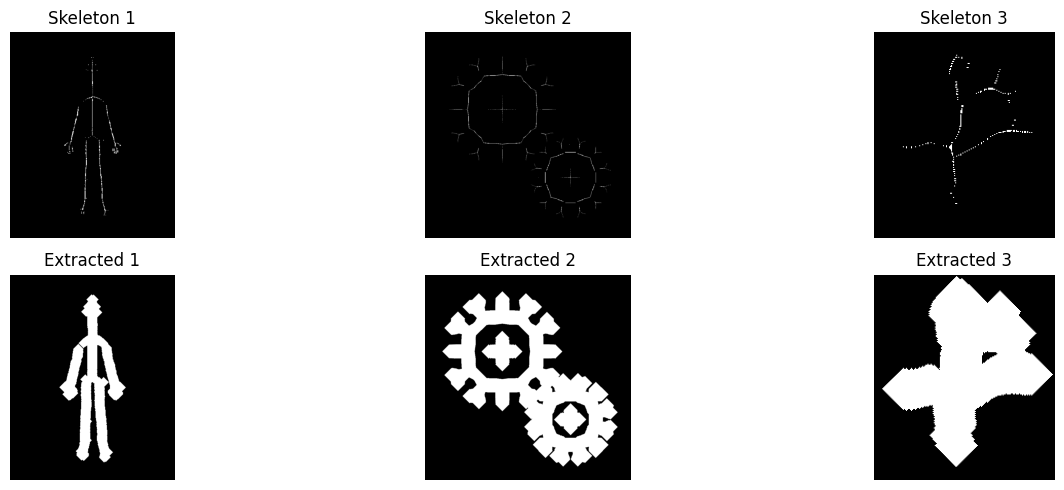

In [25]:
# Extract skeleton
def reconstruct_from_skeleton(skeleton, iterations=1):
    se = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    extracted = cv2.dilate(skeleton, se, iterations=iterations)
    return extracted

# Apply skeletonization for images
r1 = reconstruct_from_skeleton(s1, iterations= 11)
r2 = reconstruct_from_skeleton(s2, iterations= 27)
r3 = reconstruct_from_skeleton(s3, iterations= 20)

# Plot the original and skeleton images
plt.figure(figsize=(15, 5))

# Image 1
plt.subplot(2, 3, 1)
plt.imshow(s1, cmap='gray')
plt.title("Skeleton 1")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(r1, cmap='gray')
plt.title("Extracted 1")
plt.axis("off")

# Image 2
plt.subplot(2, 3, 2)
plt.imshow(s2, cmap='gray')
plt.title("Skeleton 2")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(r2, cmap='gray')
plt.title("Extracted 2")
plt.axis("off")

# Image 3
plt.subplot(2, 3, 3)
plt.imshow(s3, cmap='gray')
plt.title("Skeleton 3")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(r3, cmap='gray')
plt.title("Extracted 3")
plt.axis("off")

plt.tight_layout()
plt.show()
